In [1]:
%matplotlib notebook

import numpy as np
import numpy.linalg
import numpy.matlib
import matplotlib.pyplot as plt
from ipywidgets import interact 


def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    if numpy.linalg.norm(vector) == 0:
        return vector
    return vector / numpy.linalg.norm(vector)


def normalize_rows(x):
    """
    function that normalizes each row of the matrix x to have unit length.
    Args:
     ``x``: A numpy matrix of shape (n, m)
    Returns:
     ``x``: The normalized (by row) numpy matrix.
    """
    return x/numpy.linalg.norm(x, ord=2, axis=1, keepdims=True)


def angle_between(v1, v2, units='arcmin'):
    """ Returns the angle in radians between vectors 'v1' and 'v2', where 'v1' and 'v2' could be a single vectors, each,
        or equal number of vector rows, or a single vector in one side and rows of vectors in the other side ::
            >>> angle_between((1, 0, 0), (0, 1, 0), units='radian')
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0), units='radian')
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0), units='radian')
            3.141592653589793
            >>> angle_between([[1, 0, 0],[1, 0, 0]], [[-1, 0, 0],[0, 1, 0]], units='radian')
            [3.14159265, 1.57079633]
            >>> angle_between([1, 0, 0], [[-1, 0, 0],[0, 1, 0]], units='radian')
            [3.14159265, 1.57079633]
    """
    unit = 1.
    if units == 'radian':
        unit = 1.
    if units == 'degree':
        unit = 180. / np.pi
    if units == 'arcmin':
        unit = 60. * 180. / np.pi

    if (len(np.shape(v1)) == 1) and (len(np.shape(v2)) == 2):
        v1 = numpy.matlib.repmat(v1, np.shape(v2)[0], 1)
    if (len(np.shape(v1)) == 2) and (len(np.shape(v2)) == 1):
        v2 = numpy.matlib.repmat(v2, np.shape(v1)[0], 1)
    if (len(np.shape(v1)) == 1) and (len(np.shape(v2)) == 1):
        v1_u = unit_vector(v1)
        v2_u = unit_vector(v2)
        return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)) * unit
    if (len(np.shape(v1)) == 2) or (len(np.shape(v2)) == 2):
        dot = np.einsum('ijk,ijk->ij', [v1, v1, v2], [v2, v1, v2])
        return np.arccos(dot[0, :] / (np.sqrt(dot[1, :]) * np.sqrt(dot[2, :]))) * unit


def calcEye(gaze=5.):
    # Eye Constants
    EBC2CorneaApex = 13.5  # [mm]
    P2CorneaApex = 3.5  # [mm]
    EBradius = 12.0  # [mm]
    CorneaRadius = 8.0  # [mm]
    IrisRadius = 13.0 / 2  # [mm]
    PupilRadius = 2.0  # [mm]
    coneOfSphericalCornea = 70.  # [deg]
    coneOfNonSphericalEBC = 86.  # [deg]

    # Simulation conditions
    gazeRAD = [np.radians(gaze), 0]

    # EBC
    EBC = np.array([0., 0., 0.])  # [mm] EBC

    # Pupil
    P = EBC + (EBC2CorneaApex - P2CorneaApex) * np.array([np.cos(gazeRAD[0]), np.sin(gazeRAD[0]), 0])
    P0 = EBC + (EBC2CorneaApex - P2CorneaApex) * np.array([np.cos(0), np.sin(0), 0])
                                                        # Optics assume to zero at nominal conditions (@ gazeRAD = 0)
    # Cornea
    C = EBC + (EBC2CorneaApex - CorneaRadius) * np.array([np.cos(gazeRAD[0]), np.sin(gazeRAD[0]), 0])

    # Eye dictionary
    eye = {'EBC': EBC,
           'Gaze': np.array([gazeRAD, 0]),
           'pupil': P,
           'cornea': C,
           'Led': np.array([[27, 10, 0],
                            [27, 5, 0],
                            [27, 0, 0],
                            [27, -5, 0],
                            [27, -10, 0]]),
           'Cam': np.array([27, -15, 0]),
           # 'Cam': np.array([27, -7, 0]),
           'Eyepiece': np.array([[30, 17, 0], [30, -17, 0]]),  # [mm] Eyepiece corners
           'CVG': np.array([[30, 17, 0], [30, -17, 0]]),  # [mm] converge point for the lightfield
           }

    # Optical setup
    camera_resolution = 400.  # [pixels]
    camera_FoV = 70.   # [deg]
    optic_resolution = camera_FoV / camera_resolution * 60.  # [arcmin/pixel]

    # glint points in 3D
    C2Led = normalize_rows(eye['Led'] - C)  # cornea to led unit vector
    C2Cam = unit_vector(eye['Cam'] - C)  # cornea to Camera unit vector
    C2Cam = numpy.matlib.repmat(C2Cam, np.shape(C2Led)[0], 1)
    halfAng = np.mean([C2Led, C2Cam], axis=0)  # for unit vectors half angle is mean between camera and led

    # Invalidation of glints outside the spherical cornea model (i.e. on limbus)
    halfAng[angle_between(P-C, halfAng, 'degree') > coneOfSphericalCornea / 2.] = [np.nan, np.nan, np.nan]
    eye['glint'] = C + CorneaRadius * normalize_rows(halfAng)  # the glint point on cornea

    #  EBC contour
    t = np.radians(np.linspace(coneOfNonSphericalEBC / 2, 360. - coneOfNonSphericalEBC / 2, 200)) + gazeRAD[0]  # For EBC
    eye['EBcontour'] = numpy.matlib.repmat(EBC[:2], len(t), 1) + EBradius * np.array([np.cos(t), np.sin(t)]).T

    # Cornea contours
    t = np.radians(np.linspace(-coneOfSphericalCornea / 2, coneOfSphericalCornea / 2, 50)) + gazeRAD[0]  # For Cornea
    eye['Ccontour'] = numpy.matlib.repmat(C[:2], len(t), 1) + CorneaRadius * np.array([np.cos(t), np.sin(t)]).T
    t = np.radians(np.linspace(0, 360, 361)) + gazeRAD[0] - np.radians(90)  # For Modeled Cornea
    eye['Ccontour_model'] = numpy.matlib.repmat(C[:2], len(t), 1) + CorneaRadius * np.array([np.cos(t), np.sin(t)]).T

    # Pupil lines
    eye['Pcontour'] = np.array([
                    (P[:2] + PupilRadius * np.array([np.cos(gazeRAD[0] + np.radians(90)), np.sin(gazeRAD[0] + np.radians(90))])),
                    (P[:2] + IrisRadius * np.array([np.cos(gazeRAD[0] + np.radians(90)), np.sin(gazeRAD[0] + np.radians(90))])),
                    (P[:2] - PupilRadius * np.array([np.cos(gazeRAD[0] + np.radians(90)), np.sin(gazeRAD[0] + np.radians(90))])),
                    (P[:2] - IrisRadius * np.array([np.cos(gazeRAD[0] + np.radians(90)), np.sin(gazeRAD[0] + np.radians(90))]))])
    Cam = numpy.matlib.repmat(eye['Cam'], np.shape(C2Led)[0], 1)

    # Glint beams
    eye['glint_beam'] = np.array([Cam, eye['glint'], eye['Led']])

    # Limbus lines
    eye['limbus'] = np.array([eye['EBcontour'][-1], eye['Ccontour'][0], eye['Ccontour'][-1], eye['EBcontour'][0]])

    # Lightfield beams
    n = np.linspace(-5, 5, 7)
    contLine = 0.3
    EPpoint = numpy.matlib.repmat(eye['Eyepiece'][0] - eye['Eyepiece'][-1], len(n), 1) * \
              numpy.matlib.repmat(n, 3, 1).T / len(n) + \
              numpy.matlib.repmat(np.mean(eye['Eyepiece'], axis=0), len(n), 1)  # Points on the eyepiece where the beam emitted
    eye['lightfieldX'] = np.zeros([np.shape(eye['CVG'][1])[0] - 1, len(n), 2])
    eye['lightfieldY'] = np.zeros([np.shape(eye['CVG'][1])[0] - 1, len(n), 2])
    for ii in range(np.shape(eye['CVG'][0])[0] - 1):  # convergence points
        for jj in range(len(n)):  # Lightfield beams
            eye['lightfieldX'][ii, jj, :] = np.array([EPpoint[jj, 0],
                                                      (1+contLine) * eye['CVG'][ii, 0] - contLine * EPpoint[jj, 0]])
            eye['lightfieldY'][ii, jj, :] = np.array([EPpoint[jj, 1],
                                                      (1+contLine) * eye['CVG'][ii, 1] - contLine * EPpoint[jj, 1]])

    # Glint pixel on camera (measured from y-axis - could be more than resolution)
    eye['Ppixel'] = angle_between(P0 - eye['Cam'], P - eye['Cam']) / optic_resolution
    eye['Gpixel'] = angle_between(P0 - eye['Cam'], eye['glint'] - eye['Cam'],
                                  units='arcmin') / optic_resolution
    # eye.Gpixel(2) = angle_between(P0'-eye.Cam', eye.glint(:,2)-eye.Cam') / optic_resolution;
    # eye.Gpixel(3) = angle_between(P0'-eye.Cam', eye.glint(:,3)-eye.Cam') / optic_resolution;
    return eye


def plotEye(eye):
    ax.plot(eye['Ccontour'].T[0], eye['Ccontour'].T[1], 'b', linewidth=2, markersize=12)
    ax.plot(eye['Ccontour_model'].T[0], eye['Ccontour_model'].T[1], ':b', linewidth=2, markersize=12)  # continue the
                                                                                    # cornea with dotted line
    ax.plot(eye['EBcontour'].T[0], eye['EBcontour'].T[1], 'b', linewidth=2, markersize=12)
    ax.plot(eye['limbus'].T[0][0:2], eye['limbus'].T[1][0:2], 'g', linewidth=2, markersize=12)  # Bottom limbus
    ax.plot(eye['limbus'].T[0][2:4], eye['limbus'].T[1][2:4], 'g', linewidth=2, markersize=12)  # top limbus
    ax.plot(eye['Pcontour'].T[0][0:2], eye['Pcontour'].T[1][0:2], 'c', linewidth=4, markersize=12)
    ax.plot(eye['Pcontour'].T[0][2:4], eye['Pcontour'].T[1][2:4], 'c', linewidth=4, markersize=12)
    ax.plot(eye['Eyepiece'].T[0]  , eye['Eyepiece'].T[1], 'g', linewidth=4, markersize=12)
    ax.plot(eye['Eyepiece'].T[0] - 1.0, eye['Eyepiece'].T[1], 'r', linewidth=4, markersize=12)
    ax.plot(eye['Eyepiece'].T[0] - 0.5, eye['Eyepiece'].T[1], 'b', linewidth=4, markersize=12)
    ax.plot(eye['Led'].T[0], eye['Led'].T[1], 'ro', linewidth=2, markersize=12)
    ax.plot(eye['Led'].T[0]+1.0, eye['Led'].T[1], 'rs', linewidth=2, markersize=12)
    ax.plot(eye['pupil'][0], eye['pupil'][1], 'ob', linewidth=2, markersize=12)
    ax.text(eye['pupil'][0], eye['pupil'][1], 'P -> ', horizontalalignment='right', verticalalignment='center')
    ax.plot(eye['cornea'][0], eye['cornea'][1], 'ob', linewidth=2, markersize=12)
    ax.text(eye['cornea'][0], eye['cornea'][1], 'C -> ', horizontalalignment='right', verticalalignment='center')
    ax.plot(eye['EBC'][0], eye['EBC'][1], 'ob', linewidth=2, markersize=12)
    ax.text(eye['EBC'][0], eye['EBC'][1], 'Eye Rotation -> ', horizontalalignment='right', verticalalignment='center')
    ax.plot(eye['Cam'][0], eye['Cam'][1], '>m', linewidth=2, markersize=15)
    ax.plot(eye['Cam'][0]+1.0, eye['Cam'][1], 'sm', linewidth=2, markersize=15)
    ax.text(eye['Cam'][0], eye['Cam'][1], 'Cam ->   ', horizontalalignment='right', verticalalignment='center')
    for i in range(np.shape(eye['glint_beam'])[1]):
        ax.plot(eye['glint_beam'][:, i, 0], eye['glint_beam'][:, i, 1], ':r', linewidth=1, markersize=12)
    str1=''
    for i in range(len(eye['Gpixel'])):
        str1 = str1 + '% 3.1f  '%(eye['Gpixel'][i])
    ax.text(eye['EBC'][0] - 13.5, eye['EBC'][1] + 15.5, 'Glint pixel: ' + str1)
    ax.text(eye['EBC'][0] - 13.5, eye['EBC'][1] + 13.5, 'Pupil pixel: ' + '% 3.1f'%(eye['Ppixel']))
    ax.axis('equal')
    ax.set_xlim((eye['EBC'][0] - 15., eye['EBC'][0] + 30.))
    ax.set_ylim((eye['EBC'][1] - 17., eye['EBC'][1] + 17.))
    ax.set_xticks(np.arange(int((eye['EBC'][0] - 15.)/5)*5, int((eye['EBC'][0] + 45.)/5)*5, step=5.))
    ax.set_yticks(np.arange(int((eye['EBC'][1] - 17.)/5)*5, int((eye['EBC'][1] + 17.)/5)*5, step=5.))
    ax.grid('on', color='gray', linewidth=0.5)

def update(gaze):
    eye = calcEye(gaze=gaze)
    ax.clear()
    plotEye(eye=eye)

<IPython.core.display.Javascript object>


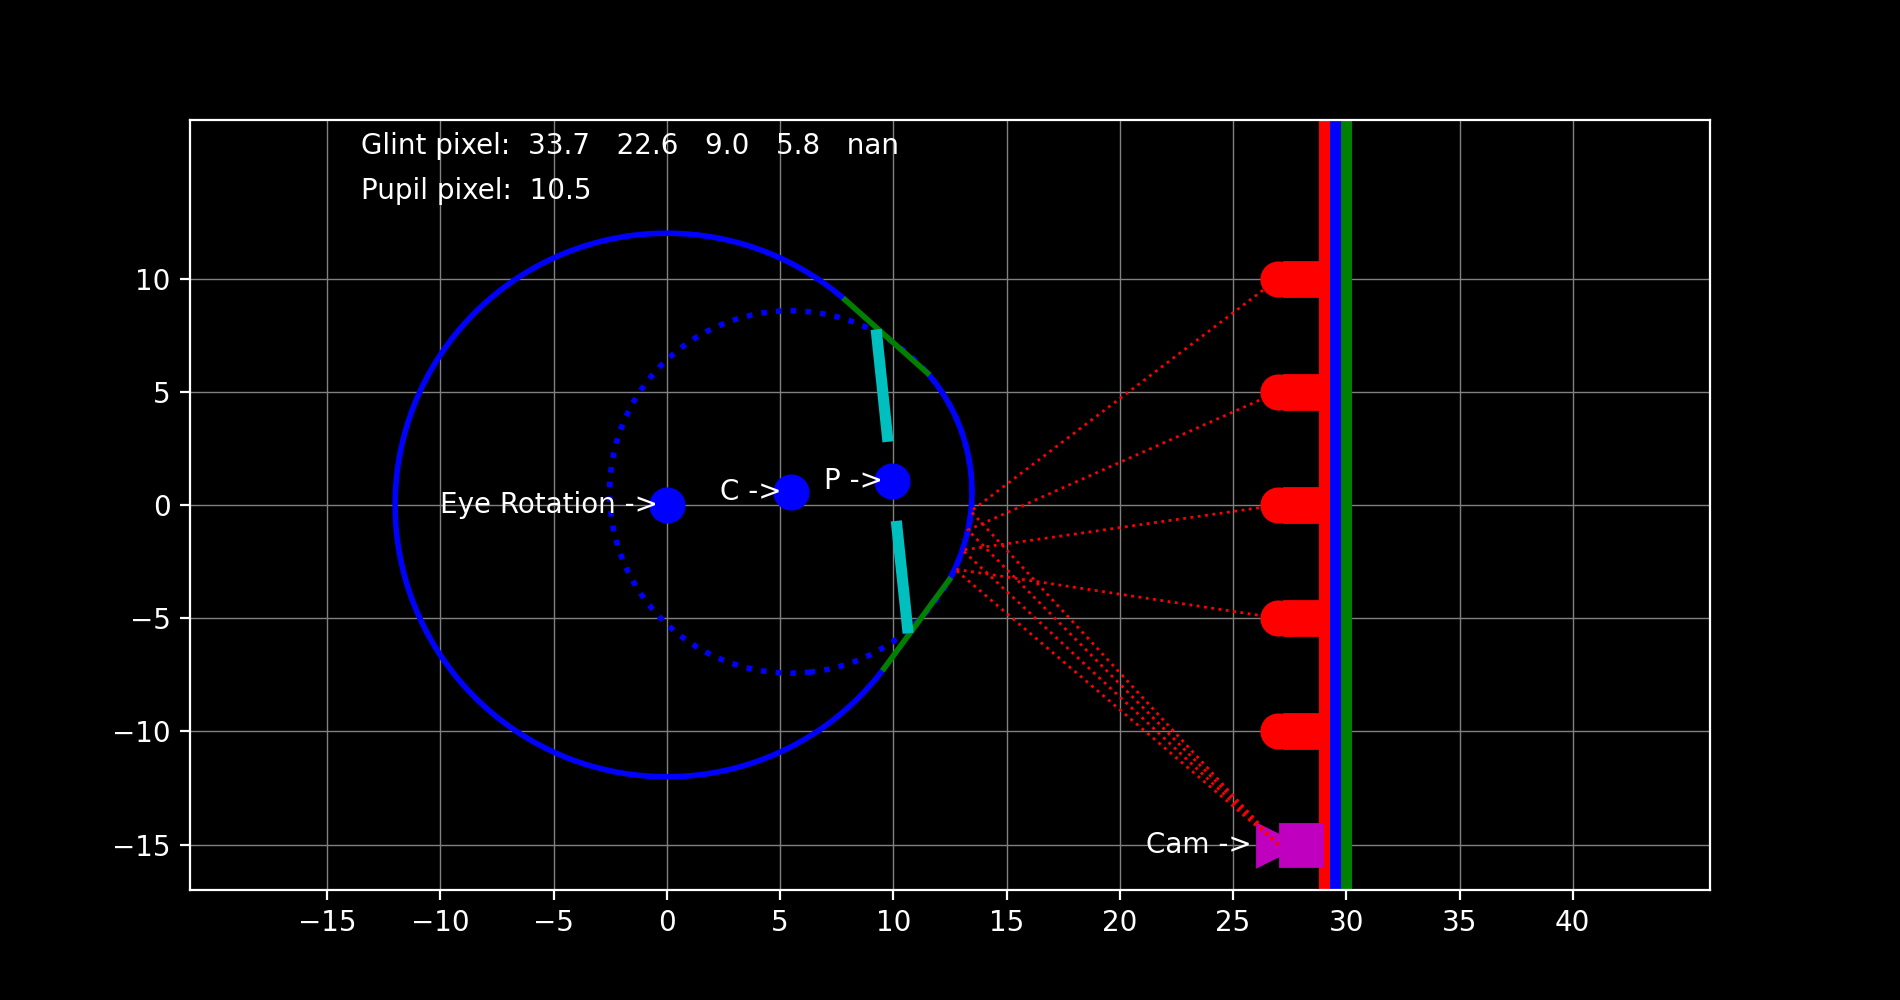

interactive(children=(IntSlider(value=0, description='gaze', max=25, min=-25), Output()), _dom_classes=('widge…

<function __main__.update(gaze)>

In [2]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(9.5, 5))
plt.subplots_adjust(left=0.1)
update(gaze=5)
interact(update, gaze=(-25,25,1))